# Effect of History

The update data has labels perturbed according to the model's FPR. However, the initial training data is static. This means that it can be used as a sort of anchor to make sure that the model's predictions on that data do not deviate too much.

1. Preventing prediction deviation on original training set will also prevent FPR from increasing.
2. We might not trust older data as definitions of disease change over time, so we need to balance this

In [9]:
import copy
import importlib
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import torch

import sklearn.linear_model as linear_model

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import utils
importlib.reload(utils)
from utils import eval_model, perturb_labels_fp, update_model_feedback_with_training, make_gaussian_data

%matplotlib inline

In [3]:
n_train = 10000
n_update = 10000
n_test = 50000

## Gold Standard

If we magically have the training data and update data at the time of first learning the model, then the best we can do is train on both datasets. Let's do this and see the "gold standard" performance of our classifier

In [4]:
seeds = np.arange(100)
gold_standard = {"fpr": [], "tpr": [], "fnr": [], "tnr": []}

for seed in seeds:
    np.random.seed(seed)

    x, y = make_classification(n_train + n_update + n_test, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
    x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)
    
    model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
    model.fit(np.concatenate((x_train, x_update)), np.concatenate((y_train, y_update)))
    
    y_pred = model.predict(x_test)
    tnr, fpr, fnr, tpr = eval_model(y_test, y_pred)
    
    gold_standard["fpr"].append(fpr)
    gold_standard["tpr"].append(tpr)
    gold_standard["fnr"].append(fnr)
    gold_standard["tnr"].append(tnr)

In [5]:
results = {"type": [], "rate": []}

for key in gold_standard.keys():
    results["type"] += [key] * len(gold_standard[key])
    results["rate"] += gold_standard[key]

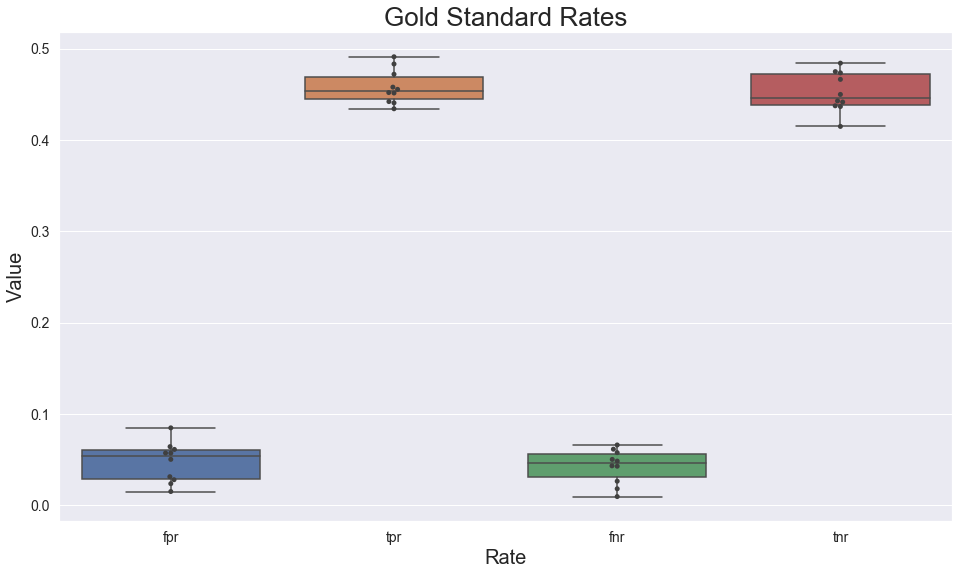

In [7]:
data = pd.DataFrame(results)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="type", y="rate", data=data, ax=ax)
sns.swarmplot(x="type", y="rate", data=data, color=".25", ax=ax)
ax.set_xlabel("Rate", size=20)
ax.set_ylabel("Value", size=20)
ax.set_title("Gold Standard Rates", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

## Online Update with Training Data

### All Training Data

First we look at what happens when doing online updates that include all training data, then move on to including increasingly smaller subsets of training

In [21]:
seeds = np.arange(100)
num_updates = [1, 5, 10, 25, 50, 100]
initial_results = {update: {"fpr": [], "tpr": [], "fnr": [], "tnr": []} for update in num_updates}
updated_results = {update: {"fpr": [], "tpr": [], "fnr": [], "tnr": []} for update in num_updates}

for seed in seeds:
    for update in num_updates:
        np.random.seed(seed)

        x, y = make_classification(n_train + n_update + n_test, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
        x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)

        model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
        model.fit(x_train, y_train)

        y_pred = model.predict(x_test)
        initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

        initial_results[update]["fpr"].append(initial_fpr)
        initial_results[update]["tpr"].append(initial_tpr)
        initial_results[update]["fnr"].append(initial_fnr)
        initial_results[update]["tnr"].append(initial_tnr)

        new_model = update_model_feedback_with_training(model, x_train, y_train, x_update, y_update, update)
        y_pred = new_model.predict(x_test)
        updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

        updated_results[update]["fpr"].append(updated_fpr)
        updated_results[update]["tpr"].append(updated_tpr)
        updated_results[update]["fnr"].append(updated_fnr)
        updated_results[update]["tnr"].append(updated_tnr)

In [23]:
data = {"type": [], "rate": [], "time": [], "updates": []}

for update in num_updates:
    for key in initial_results[update].keys():
        data["type"] += [key] * len(initial_results[update][key])
        data["rate"] += initial_results[update][key]
        data["time"] += ["initial"] * len(initial_results[update][key])
        data["updates"] += [update] * len(initial_results[update][key])

for update in num_updates:
    for key in updated_results[update].keys():
        data["type"] += [key] * len(updated_results[update][key])
        data["rate"] += updated_results[update][key]
        data["time"] += ["updated"] * len(updated_results[update][key])
        data["updates"] += [update] * len(updated_results[update][key])

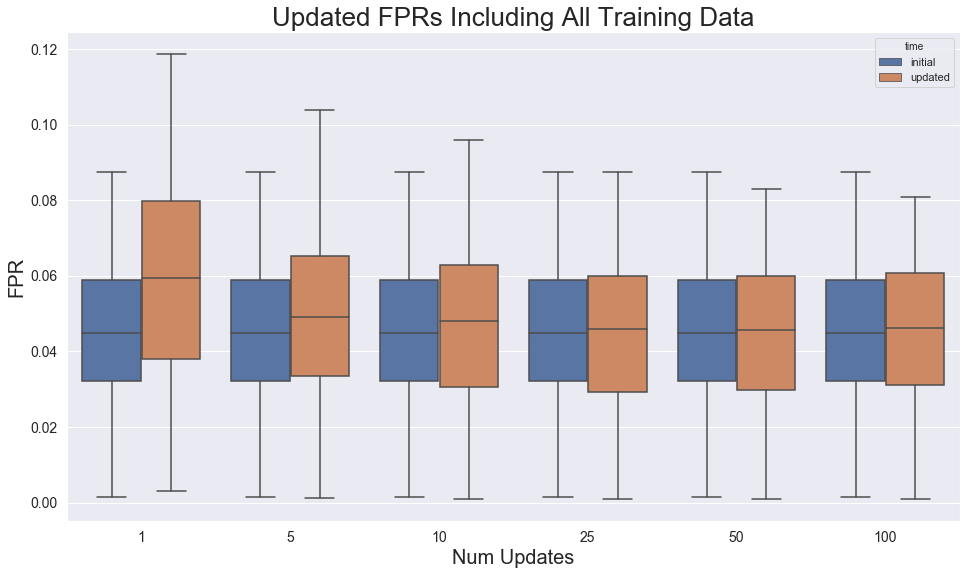

In [32]:
data = pd.DataFrame(data)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.boxplot(x="updates", y="rate", hue="time", data=data.loc[data["type"] == "fpr"], ax=ax)
# sns.swarmplot(x="type", y="rate", hue="time", data=data, color=".25", ax=ax)
ax.set_xlabel("Num Updates", size=20)
ax.set_ylabel("FPR", size=20)
ax.set_title("Updated FPRs Including All Training Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

### Subset Training Data

In [40]:
seeds = np.arange(100)
num_updates = [1, 5, 10, 25, 50, 100]
train_percentages = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
initial_results = {update: {train_percentage: {"fpr": [], "tpr": [], "fnr": [], "tnr": []} for train_percentage in train_percentages} for update in num_updates}
updated_results = {update: {train_percentage: {"fpr": [], "tpr": [], "fnr": [], "tnr": []} for train_percentage in train_percentages} for update in num_updates}

for seed in seeds:
    for update in num_updates:
        for train_percentage in train_percentages:
            np.random.seed(seed)

            x, y = make_classification(n_train + n_update + n_test, n_informative=2, n_features=2, n_classes=2, n_clusters_per_class=2 ,n_redundant=0, flip_y=0, class_sep=1.0)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_update + n_test)
            x_update, x_test, y_update, y_test = train_test_split(x_test, y_test, test_size=n_test)

            model = linear_model.SGDClassifier(max_iter=10000, tol=1e-3, warm_start=True, loss="log")
            model.fit(x_train, y_train)

            y_pred = model.predict(x_test)
            initial_tnr, initial_fpr, initial_fnr, initial_tpr = eval_model(y_test, y_pred)

            initial_results[update][train_percentage]["fpr"].append(initial_fpr)
            initial_results[update][train_percentage]["tpr"].append(initial_tpr)
            initial_results[update][train_percentage]["fnr"].append(initial_fnr)
            initial_results[update][train_percentage]["tnr"].append(initial_tnr)

            x_train_sub, _, y_train_sub, __ = train_test_split(x_train, y_train, test_size=1-train_percentage)

            new_model = update_model_feedback_with_training(model, x_train_sub, y_train_sub, x_update, y_update, update)
            y_pred = new_model.predict(x_test)
            updated_tnr, updated_fpr, updated_fnr, updated_tpr = eval_model(y_test, y_pred)

            updated_results[update][train_percentage]["fpr"].append(updated_fpr)
            updated_results[update][train_percentage]["tpr"].append(updated_tpr)
            updated_results[update][train_percentage]["fnr"].append(updated_fnr)
            updated_results[update][train_percentage]["tnr"].append(updated_tnr)

In [41]:
data = {"type": [], "rate": [], "time": [], "updates": [], "train_percentage": []}

for update in num_updates:
    for train_percentage in train_percentages:
        for key in initial_results[update][train_percentage].keys():
            data["type"] += [key] * len(initial_results[update][train_percentage][key])
            data["rate"] += initial_results[update][train_percentage][key]
            data["time"] += ["initial"] * len(initial_results[update][train_percentage][key])
            data["updates"] += [update] * len(initial_results[update][train_percentage][key])
            data["train_percentage"] += [train_percentage] * len(initial_results[update][train_percentage][key])

for update in num_updates:
    for train_percentage in train_percentages:
        for key in updated_results[update][train_percentage].keys():
            data["type"] += [key] * len(updated_results[update][train_percentage][key])
            data["rate"] += updated_results[update][train_percentage][key]
            data["time"] += ["updated"] * len(updated_results[update][train_percentage][key])
            data["updates"] += [update] * len(updated_results[update][train_percentage][key])
            data["train_percentage"] += [train_percentage] * len(updated_results[update][train_percentage][key])

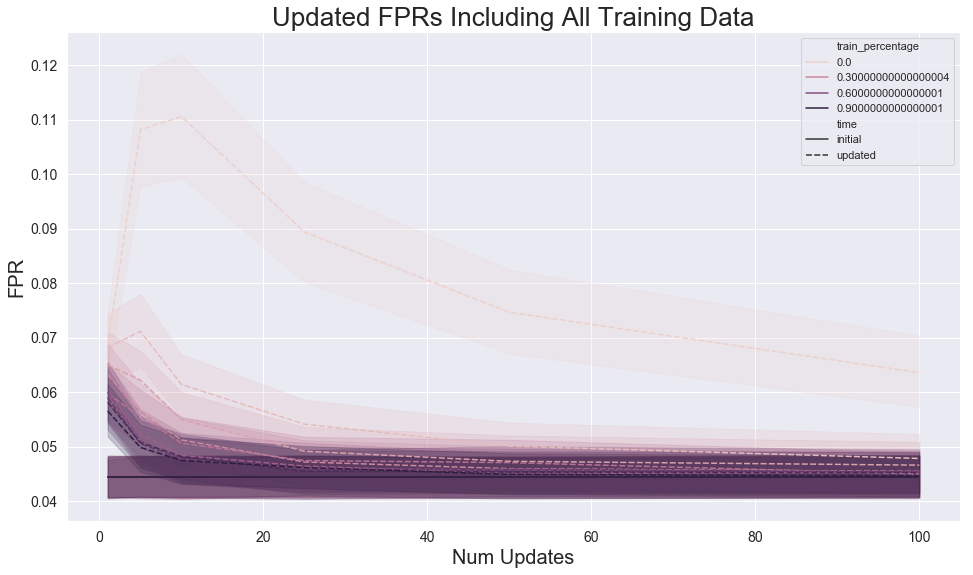

In [42]:
data = pd.DataFrame(data)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
sns.lineplot(x="updates", y="rate", style="time", hue="train_percentage", data=data.loc[data["type"] == "fpr"], ax=ax)
ax.set_xlabel("Num Updates", size=20)
ax.set_ylabel("FPR", size=20)
ax.set_title("Updated FPRs Including All Training Data", size=26)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)